#  Application of Bayesian Optimization and Regression Analysis to Ferromagnetic Materials Development
BO Method for optimizing structure-property relationships in FeGaC thin films.
This is an example notebook. For more information on this method, please refer to our paper at 
https://ieeexplore.ieee.org/document/9599674


## Alexandria Will-Cole (NEU)

## Aaron Gilad Kusne, and Peter Tonner (NIST) ¶ 

Import the necessary libraries

In [6]:
# --- Import libraries
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import matplotlib.colorbar
import matplotlib as mpl
import GPy    #From Sheffield ML Group
import GPyOpt #From Sheffield ML Group
import math
from numpy.random import seed

This is an example of Bayesian Optimization for maximizing magnetostriction constant in FeGaC with respect to two stoichiometric parameters (at% C and Fe/Ga ratio). This uses a gaussian process surrogate function with radial basis function kernel. The next composition to explore is determined via expected improvement acquisition function.

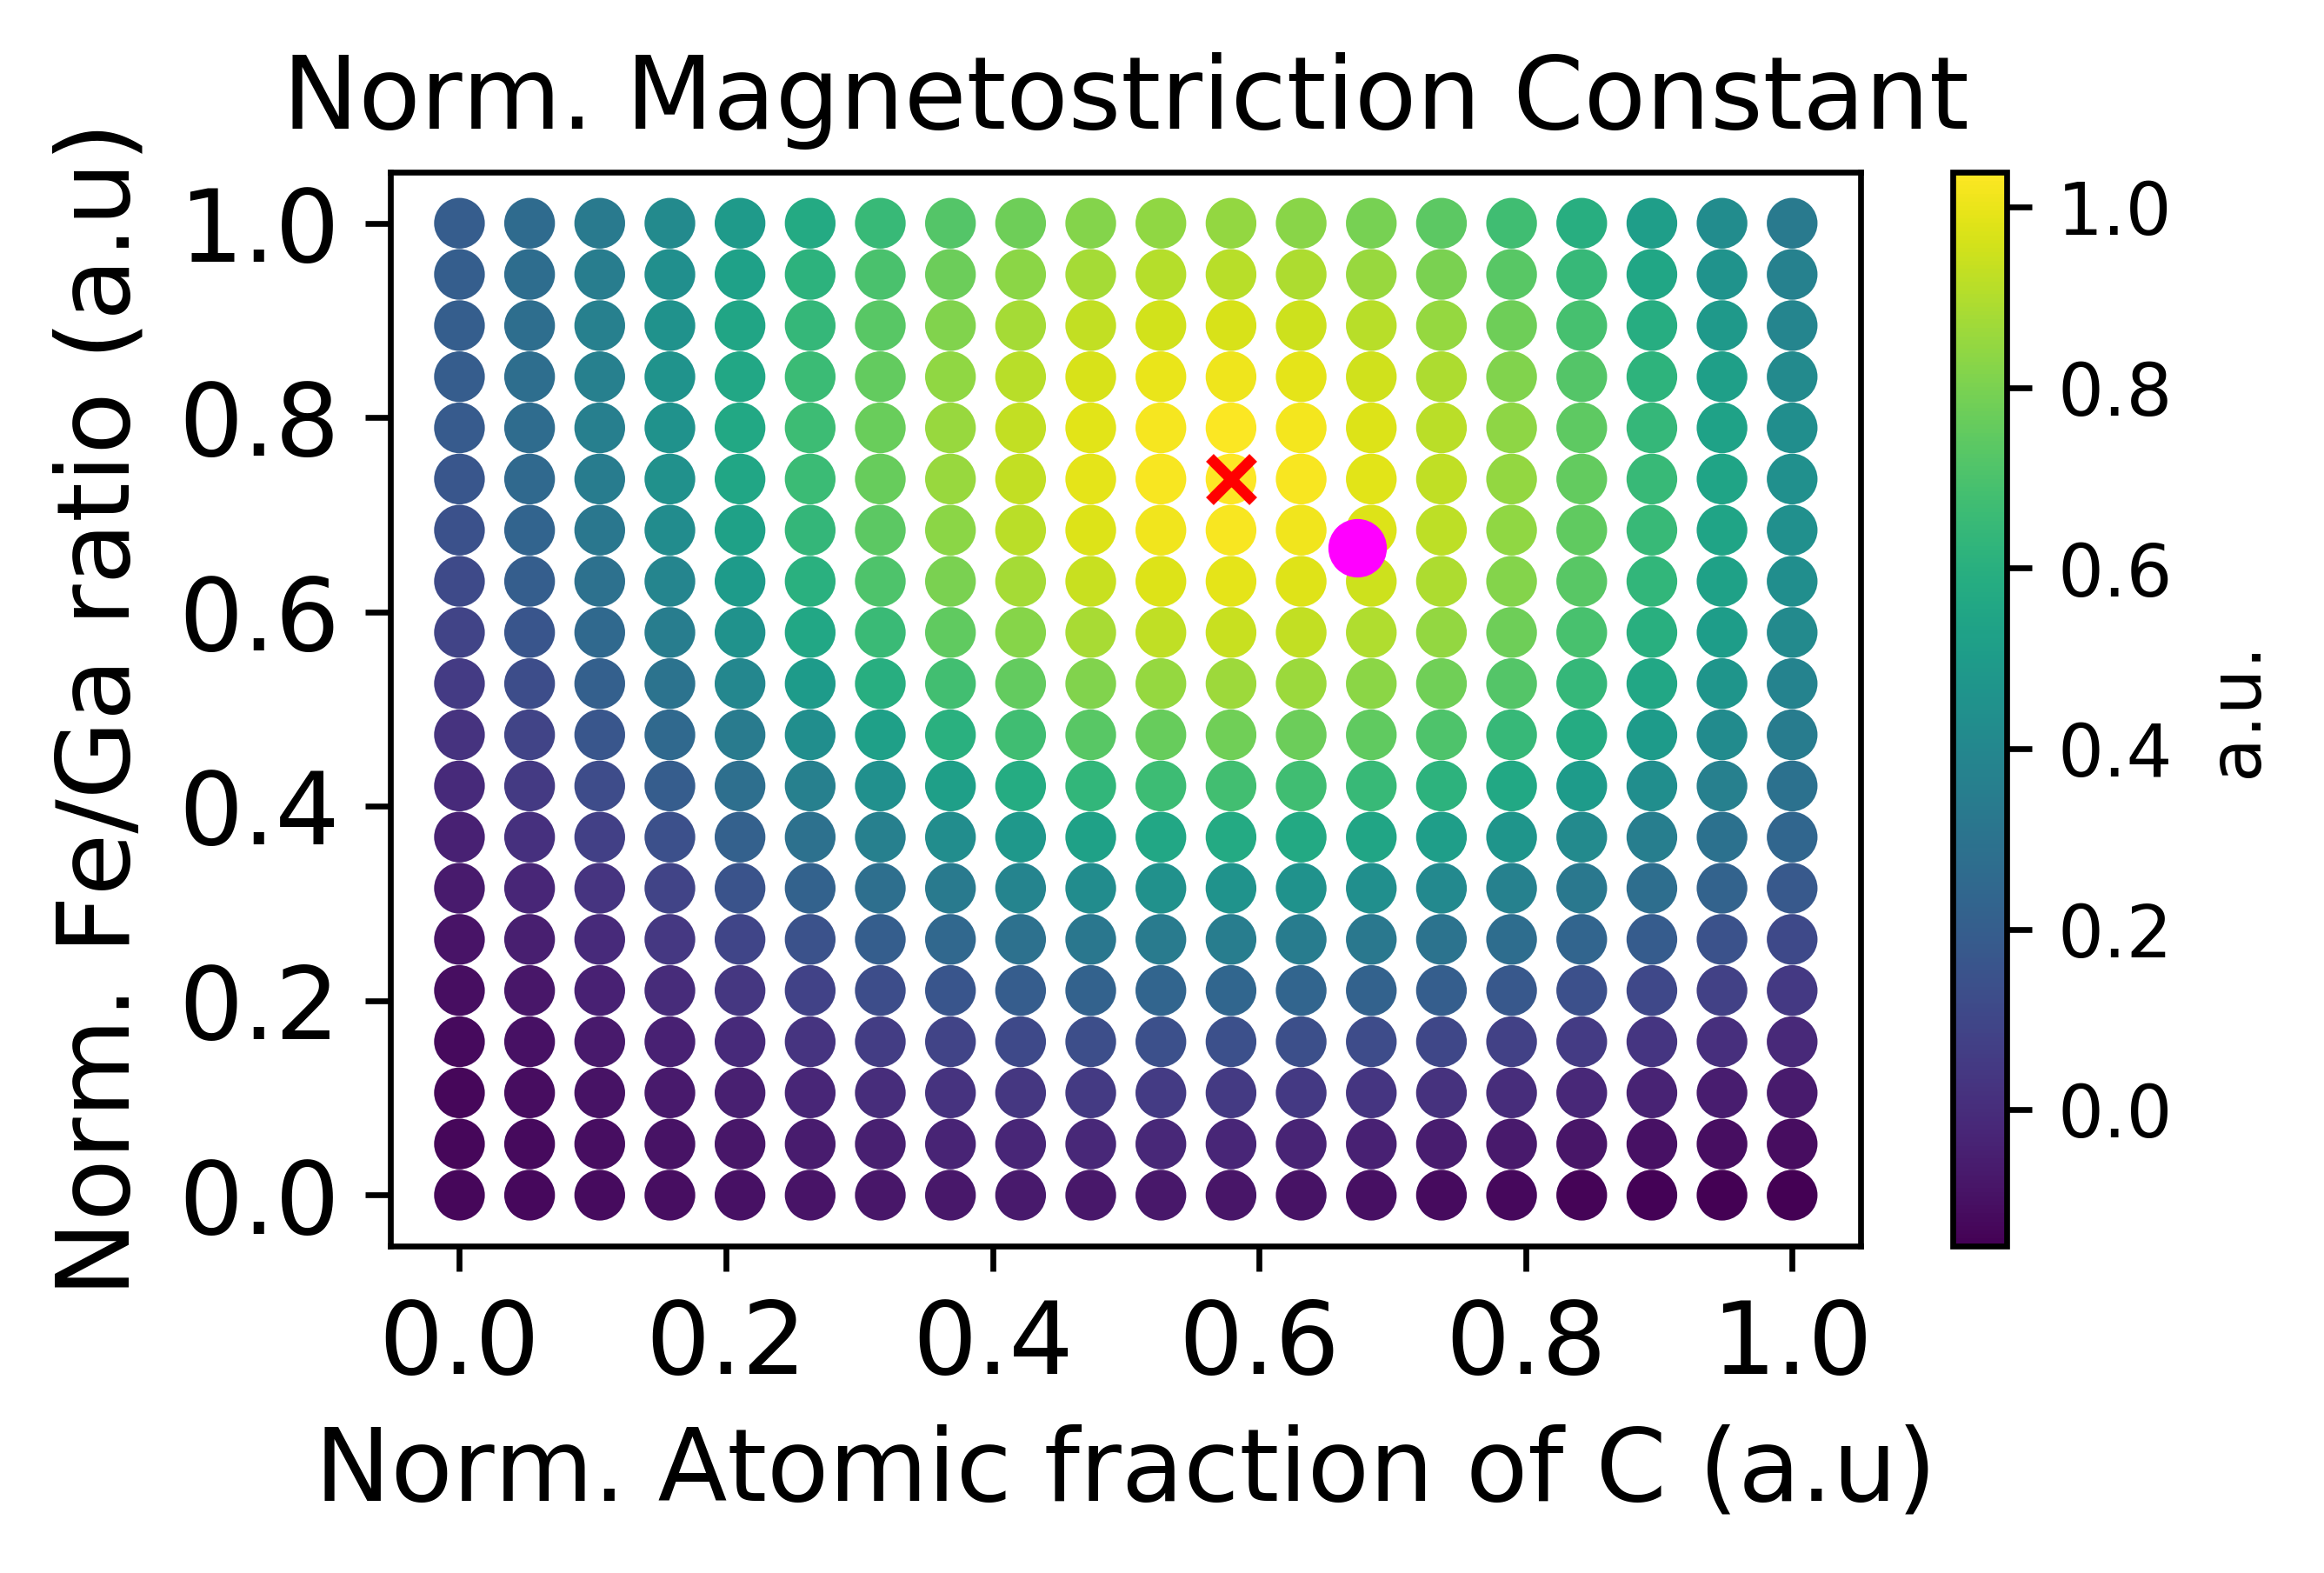

In [8]:
# --- Input the process parameters for the growth
X_step = np.array([[15.07,2.29],[17.92,7.45],[16.06,11.81],[13.46,16.84],[1.28,7.46],[12.13,11.32]]) #C content (at%) and FeGa ratio
# --- Input the objectives of interest  - magnetostriction constant h
Y_step = np.array([[2.3], [40.33], [80.99], [93.28], [10.6], [125.36]]) # magnetostriction constant (ppm) --> desireable to maximize

# --- Normalize xi input data between 0 and 1 for scaling
a=[18,17] # 0 must match maximum for domain of B content, 1 must match maximum for domain of Fe/Ga ratio
X_step = X_step/a

# --- Normalize Fi input data between 0 to 1 for scaling
a=126  #must match maximum of data for magnetostriction constant (ppm)
#b=700 #must match maximum of data for FMR linewidth (Oe)
Y_step = Y_step/a
#Z_step = Z_step/b

# --- Set up GP for a 2 dimensional input
# rbf kernel settings
d = 2      #input dimension
var = 1.    #variance
theta = 0.05 #length scale
k1 = GPy.kern.RBF(d,var,theta) #radial basis function kernel

# --- Set up the model. Here our X_step is N x 2 (2 dimensional input), and output is N x 1 (1 dimensional output)
m1 = GPy.models.GPRegression(X_step, Y_step, k1)     #model for magnetostriction constant

# --- Optimize the hyperparameters
m1.optimize('bfgs', max_iters=100)

# --- Set up the domain to predict over
N = 20
x_step1 = np.linspace(0,1,N)   #ie C-content (at%) *Be sure to interpolate from the raw data
x_step2 = np.linspace(0,1,N) #ie Fe/Ga ratio        *Be sure to interpolate from the raw data
[x_step1, x_step2] = np.meshgrid(x_step1, x_step2)
X_grid = np.hstack( (x_step1.flatten()[:,None], x_step2.flatten()[:,None]) )

# --- Evaluate the model over the desired grid
mean1, Cov1 = m1.predict(X_grid, full_cov=True) #GP mean for magnetostriction constant prediction

# --- Plot the result. 
# Run this a few times to see if result changes significantly
plt.figure(figsize = (10,6), dpi=600) #Sets the figure size

#GP prediction
plt.subplot(2,2,3)
plt.scatter(X_grid[:,0],X_grid[:,1],c=mean1.flatten(), alpha=1)
plt.title('Norm. Magnetostriction Constant',fontsize=14)
plt.colorbar(label='a.u.')
plt.xlabel("Norm. Atomic fraction of C (a.u)",fontsize=14)
plt.ylabel("Norm. Fe/Ga ratio (a.u)", fontsize=14)


# set up GPyOpt
from GPyOpt.acquisitions import AcquisitionEI, AcquisitionLCB, AcquisitionMPI, AcquisitionEntropySearch
from GPyOpt import Design_space  ## GPyOpt design space
space = Design_space([{'name': 'var_1', 'type': 'continuous',  'domain': (-1, 1)}] )
from GPyOpt.models import GPModel


# Hand off the GPy learned model to GPyOpt
model = GPModel(optimize_restarts=1, verbose=False)
model.model = m1

# find the sample that maximizes the magnetostriction constant
#acquisition functions https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/devel/manual/GPyOpt_creating_new_aquisitions.ip

#expected improvement
acq_EI = AcquisitionEI(model,space) #expected improvement
acquisition_function = acq_EI.acquisition_function(X_step)
next_sample_index = np.argmax(acquisition_function)
X_step[next_sample_index],mean1[next_sample_index]
xnext=X_step[next_sample_index]
x1next=xnext[0]
x2next=xnext[1]
b=mean1.flatten()
true_max_y = np.max(mean1)
result = np.where(mean1 == true_max_y)
ind_pos_xa = [result, 0] #maximum @ C-Content
ind_pos_xb = [result, 1] #maximum @ Fe/Ga ratio



# plot next point to explore based on expected improvement
plt.scatter(x1next, x2next,color = 'magenta', marker='o', alpha=1, s=50)


# plot predicted maximum
plt.scatter(0.57894737, 0.73684211,c = 'red', marker='x', alpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

x1_un=x1next*18
x2_un=x2next*17
